In [1]:
# Import the necessary libraries needed
import pandas as pd
import seaborn as sns
import numpy as np
import arviz as az
import matplotlib.patches as mpatches
from scipy.special import expit
from utils.metrics import calculate_metrics, confidence_interval
from utils.Plots import predictions_with_uncertainty 
from matplotlib import pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

### Load the datasets and results

In [2]:
training_set = pd.read_csv("datasets/training_set.csv", index_col=0)
validation_set = pd.read_csv("datasets/validation_set.csv", index_col=0)
test_set = pd.read_csv("datasets/test_set_preprocessed.csv", index_col = 0)

df_X_train = training_set.drop('label', axis=1)
y_train = training_set['label']
df_X_val = validation_set.drop('label', axis=1)
y_val = validation_set['label']
df_X_test = test_set.drop('label', axis=1)
y_test = test_set['label']

#### Utility functions

In [3]:
def compute_pred_dist(df_eval, alphas, betas):
    pred_dist = []
    for ind in range(len(alphas)):
        lp = np.dot(df_eval, betas.iloc[ind,]) + alphas[ind]
        prob = expit(lp)
        pred_dist.append(prob)

    return pd.DataFrame(pred_dist)

#### Frequentist results

In [4]:
freq_lasso = pd.read_csv("results/frequentist_results/Frequentist_lasso.csv", index_col=0)
freq_logistic = pd.read_csv("results/frequentist_results/Frequentist_logistic.csv", index_col=0)

In [5]:
beta_values_lasso = freq_lasso.loc[:,"beta.1":"beta.763"]
alpha_values_lasso = freq_lasso.loc[:,"intercept"]
beta_values_logistic = freq_logistic.loc[:,"beta.1":"beta.763"]
alpha_values_logistic = freq_logistic.loc[:,"intercept"]

In [6]:
freq_lasso_pred_train_dist = compute_pred_dist(df_X_train, alpha_values_lasso, beta_values_lasso)
freq_lasso_val_dist = compute_pred_dist(df_X_val, alpha_values_lasso, beta_values_lasso)
freq_lasso_test_dist = compute_pred_dist(df_X_test, alpha_values_lasso, beta_values_lasso)
freq_logistic_pred_train_dist = compute_pred_dist(df_X_train, alpha_values_logistic, beta_values_logistic)
freq_logistic_val_dist = compute_pred_dist(df_X_val, alpha_values_logistic, beta_values_logistic)
freq_logistic_test_dist = compute_pred_dist(df_X_test, alpha_values_logistic, beta_values_logistic)

#### Bayesian results

In [7]:
rhs_prior = pd.read_csv("results/bayesian_results/rhs_prior_samples.csv")
rhs_posterior = pd.read_csv("results/bayesian_results/rhs_posterior_samples.csv")
wip_prior = pd.read_csv("results/bayesian_results/logistic_prior_samples.csv")
wip_posterior = pd.read_csv("results/bayesian_results/logistic_posterior_samples.csv")

In [8]:
alpha_values_rhs_prior = rhs_prior["alpha"].mean()
beta_values_rhs_prior = rhs_prior.loc[:,'beta.1':'beta.763']

alpha_values_rhs_posterior = rhs_posterior['alpha']
beta_values_rhs_posterior = rhs_posterior.loc[:,'beta.1':'beta.763']

alpha_values_wip_prior = wip_prior["alpha"].mean()
beta_values_wip_prior = wip_prior.loc[:,'beta.1':'beta.763']

alpha_values_wip_posterior = wip_posterior['alpha']
beta_values_wip_posterior = wip_posterior.loc[:,'beta.1':'beta.763']

In [9]:
rhs_prior_pred_dist = pd.DataFrame(rhs_prior[[col for col in rhs_prior.columns if "y_pred" in col]])
rhs_pred_train_dist = pd.DataFrame(rhs_posterior[[col for col in rhs_posterior.columns if "y_train_pred" in col]])
rhs_val_dist = pd.DataFrame(rhs_posterior[[col for col in rhs_posterior.columns if "y_val_pred" in col]])

wip_prior_pred_dist = pd.DataFrame(wip_prior[[col for col in wip_prior.columns if "y_pred" in col]])
wip_pred_train_dist = pd.DataFrame(wip_posterior[[col for col in wip_posterior.columns if "y_train_pred" in col]])
wip_val_dist = pd.DataFrame(wip_posterior[[col for col in wip_posterior.columns if "y_val_pred" in col]])

rhs_test_dist = np.zeros((20000, 190))

for i in range(20000):
    # Calculate the linear combination of inputs and weights
    linear_predictor = np.dot(df_X_test, beta_values_rhs_posterior.loc[i, :].T) + alpha_values_rhs_posterior[i]
    # Apply the logistic function to convert these values into probabilities
    rhs_test_dist[i, :] = 1 / (1 + np.exp(-linear_predictor))

rhs_test_dist = pd.DataFrame(rhs_test_dist)
rhs_test_dist.columns = ['y_test.' + str(i+1) for i in range(190)]

C:\Users\ravindranth\AppData\Local\Temp\ipykernel_18244\1523168161.py:15: RuntimeWarning: overflow encountered in exp
  rhs_test_dist[i, :] = 1 / (1 + np.exp(-linear_predictor))


In [10]:
predicted_probs_lasso = freq_lasso_val_dist.mean()
predicted_probs_freq_logistic = freq_logistic_val_dist.mean()
predicted_probs_rhs = rhs_val_dist.mean()
predicted_probs_wip = wip_val_dist.mean()

In [11]:
# Compute calibration curves
fraction_of_positives_lasso, mean_predicted_value_lasso = calibration_curve(y_val, predicted_probs_lasso, n_bins=20)
fraction_of_positives_freq_logistic, mean_predicted_value_freq_logistic = calibration_curve(y_val, predicted_probs_freq_logistic, n_bins=20)
fraction_of_positives_rhs, mean_predicted_value_rhs = calibration_curve(y_val, predicted_probs_rhs, n_bins=20)
fraction_of_positives_wip, mean_predicted_value_wip = calibration_curve(y_val, predicted_probs_wip, n_bins=20)

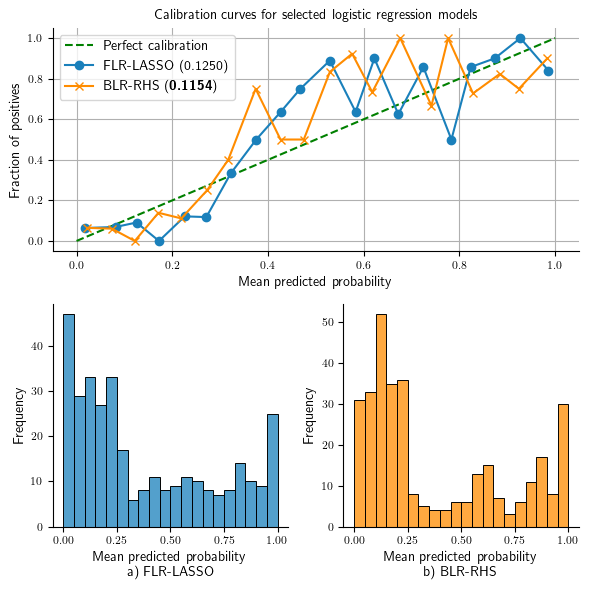

In [43]:
plt.rcParams['text.usetex'] = True

# Compute Brier Scores
brier_lasso = brier_score_loss(y_val, predicted_probs_lasso)
brier_rhs = brier_score_loss(y_val, predicted_probs_rhs)

# Set up the figure with 2 rows and 2 columns
plt.figure(figsize=(6, 6))

# 1. Calibration plot (Top row, spans both columns)
plt.subplot(2, 2, (1, 2))
plt.plot([0, 1], [0, 1], linestyle='--', label="Perfect calibration", color='green')
plt.plot(mean_predicted_value_lasso, fraction_of_positives_lasso, marker='o', 
         label=f"FLR-LASSO ({brier_lasso:.4f})", color='#1a80bb')
plt.plot(mean_predicted_value_rhs, fraction_of_positives_rhs, marker='x', 
         label=f"BLR-RHS ($\\textbf{{{brier_rhs:.4f}}}$)", color='#FF8C00')

plt.xlabel("Mean predicted probability", fontsize=10)
plt.ylabel("Fraction of positives", fontsize=10)
plt.legend(fontsize=10)
plt.grid(True)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title("Calibration curves for selected logistic regression models", fontsize=10)

# 2. Histogram for FLR-LASSO Predicted Probabilities
plt.subplot(2, 2, 3)
sns.histplot(np.array(predicted_probs_lasso), color='#1a80bb', fill=True, bins=20)
plt.xlabel("Mean predicted probability \n a) FLR-LASSO", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# 3. Histogram for BLR-RHS Predicted Probabilities
plt.subplot(2, 2, 4)
sns.histplot(np.array(predicted_probs_rhs), color='#FF8C00', fill=True, bins=20)
plt.xlabel("Mean predicted probability \n b) BLR-RHS", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Adjust layout
plt.tight_layout()
#plt.savefig("plots/predictive_checks_paper_2.pdf", bbox_inches="tight", dpi=2000)
plt.show()

#### Log mean linear predictors 

In [13]:
pr_alpha = alpha_values_rhs_prior.mean()
pr_beta_values = beta_values_rhs_prior.mean()
y_latent_pr = np.dot(df_X_train, pr_beta_values) + pr_alpha
pos_alpha = alpha_values_rhs_posterior.mean()
pos_beta_values = beta_values_rhs_posterior.mean()
y_latent_pos = np.dot(df_X_train, pos_beta_values) + pos_alpha

In [14]:
pr_alpha_wip = alpha_values_wip_prior.mean()
pr_beta_values_wip = beta_values_wip_prior.mean()
y_latent_pr_wip = np.dot(df_X_train, pr_beta_values_wip) + pr_alpha_wip
pos_alpha_wip = alpha_values_wip_posterior.mean()
pos_beta_values_wip = beta_values_wip_posterior.mean()
y_latent_pos_wip = np.dot(df_X_train, pos_beta_values_wip) + pos_alpha_wip

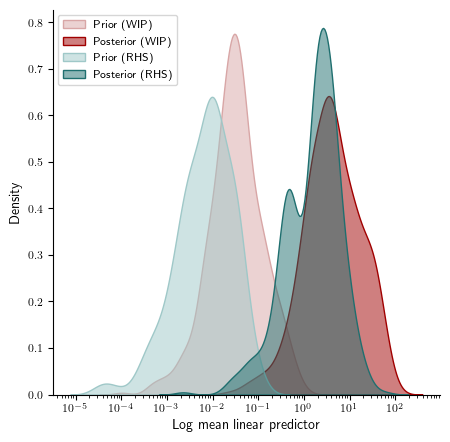

In [15]:
plt.figure(figsize=(5,5))
sns.kdeplot(y_latent_pr_wip, label="Prior (WIP)", color='#d8a6a6', fill=True, alpha = 0.5, log_scale=True)
sns.kdeplot(y_latent_pos_wip, label="Posterior (WIP)", color='#a00000', fill=True, alpha = 0.5, log_scale=True)
sns.kdeplot(y_latent_pr, label="Prior (RHS)", color='#9fc8c8', fill=True, alpha = 0.5, log_scale=True)
sns.kdeplot(y_latent_pos, label="Posterior (RHS)", color='#1f6f6f', fill=True, alpha = 0.5, log_scale=True)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.ylabel("Density", fontdict={"fontsize":10})
plt.xlabel("Log mean linear predictor", fontdict={"fontsize":10})
plt.legend(loc = "upper left", fontsize = 8)
#plt.savefig("../linear_predictors.pdf", bbox_inches = "tight", dpi = 800)
plt.show()

#### Uncertainty

##### Freqentist lasso (FLR-LASSO)

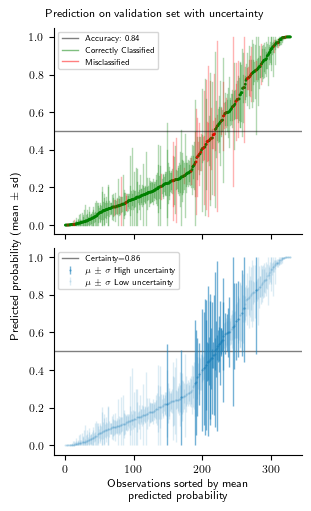

In [16]:
valid_uncertainty_lasso = predictions_with_uncertainty(freq_lasso_val_dist, y_val, method = "FLR", t = 0.5,
                                          std_factor=1, 
                                          title = "Prediction on validation set with uncertainty",
                                          use_quantile=False)
#valid_uncertainty_lasso.savefig("plots/lasso_val_uncertain.pdf", dpi = 2000, bbox_inches="tight")
valid_uncertainty_lasso.show()

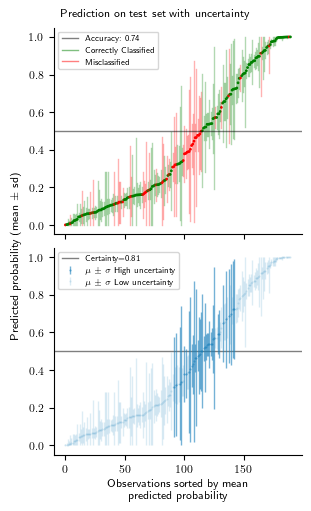

In [17]:
test_uncertainty_lasso = predictions_with_uncertainty(freq_lasso_test_dist, y_test, method = "FLR", t = 0.5,
                                          std_factor=1, 
                                          title = "Prediction on test set with uncertainty",
                                          use_quantile=False)
#test_uncertainty_lasso.savefig("plots/lasso_test_uncertain.pdf", dpi = 2000, bbox_inches="tight")
test_uncertainty_lasso.show()

##### Bayesian - regularised horse shoe (BLR-RHS)

C:\Users\ravindranth\Documents\Thesis_Paper\source\utils\Plots.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean = mean[sort]
C:\Users\ravindranth\Documents\Thesis_Paper\source\utils\Plots.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std = std[sort]


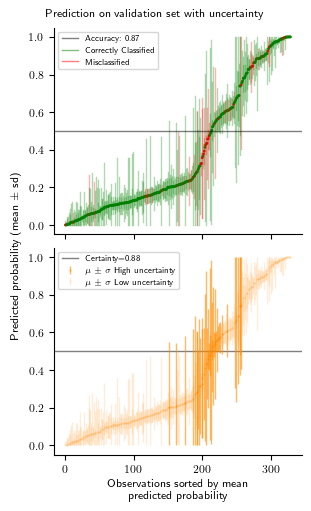

In [18]:
valid_uncertainty_rhs = predictions_with_uncertainty(rhs_val_dist, y_val, method = "BLR", t = 0.5,
                                          std_factor=1, 
                                          title = "Prediction on validation set with uncertainty",
                                          use_quantile=False)
#valid_uncertainty_rhs.savefig("plots/rhs_val_uncertain.pdf", dpi = 2000, bbox_inches="tight")
valid_uncertainty_rhs.show()

C:\Users\ravindranth\Documents\Thesis_Paper\source\utils\Plots.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean = mean[sort]
C:\Users\ravindranth\Documents\Thesis_Paper\source\utils\Plots.py:111: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std = std[sort]


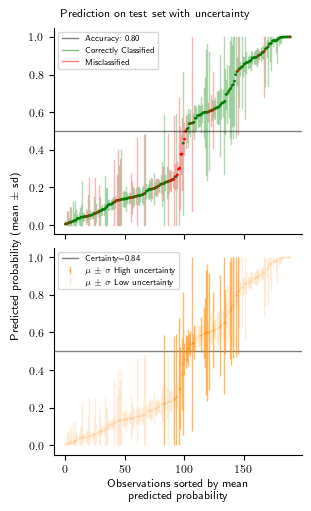

In [19]:
test_uncertainty_rhs = predictions_with_uncertainty(rhs_test_dist, y_test, method = "BLR", t = 0.5,
                                          std_factor=1, 
                                          title = "Prediction on test set with uncertainty",
                                          use_quantile=False)
#test_uncertainty_rhs.savefig("plots/rhs_test_uncertain.pdf", dpi = 2000, bbox_inches="tight")
test_uncertainty_rhs.show()

In [20]:
imp_features1 = ['beta.50', 'beta.51', 'beta.57', 'beta.139', 'beta.743', 'beta.752', 'beta.763']
imp_column_numbers = [int(beta_name.split('.')[1]) - 1 for beta_name in imp_features1]
imp_features = df_X_train.columns[imp_column_numbers]

In [21]:
frequen_lasso = beta_values_lasso.loc[:,imp_features1].T
frequen_lasso = frequen_lasso.set_index(imp_features)

bayesian_rhs = beta_values_rhs_posterior.loc[:,imp_features1].T
bayesian_rhs = bayesian_rhs.set_index(imp_features)

In [22]:
log_dict1 = {}
for i, row in frequen_lasso.iterrows():
    log_dict1[i] = list(np.array(frequen_lasso.loc[i,:]))

log_dict2 = {}
for i, row in bayesian_rhs.iterrows():
    log_dict2[i] = list(np.array(bayesian_rhs.loc[i,:]))

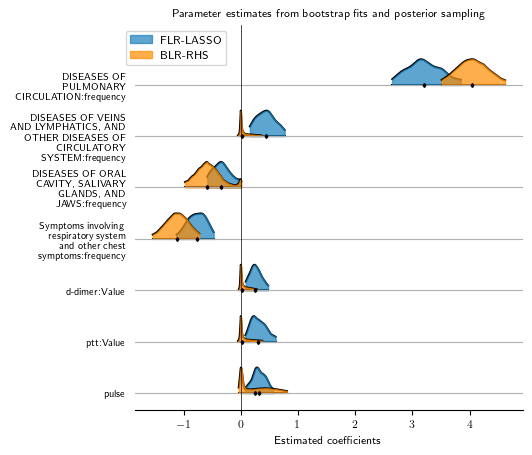

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))
az.plot_forest(
    log_dict1,
    kind="ridgeplot",
    combined=True,
    ridgeplot_truncate=True,
    ridgeplot_quantiles=[0.5],
    markersize=2,
    ridgeplot_overlap=2,
    colors="#1a80bb",
    ridgeplot_alpha=0.7,
    ax=ax
)
az.plot_forest(
    log_dict2,
    kind="ridgeplot",
    combined=True,
    ridgeplot_truncate=True,
    ridgeplot_quantiles=[0.5],
    markersize=2,
    ridgeplot_overlap=2,
    colors="#FF8C00",
    ridgeplot_alpha=0.7,
    ax=ax
)

yellow_patch = mpatches.Patch(color='#1a80bb', label='FLR-LASSO', alpha=0.7)
red_patch = mpatches.Patch(color='#FF8C00', label='BLR-RHS', alpha=0.7)

plt.legend(handles=[yellow_patch, red_patch], bbox_to_anchor=(0.25, 1), fontsize = 8)
plt.title("Parameter estimates from bootstrap fits and posterior sampling", fontsize = 8)

import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)
wrap_labels(ax, 20)

ax.axvline(x = 0, color = 'black', linewidth = 0.5)
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
plt.yticks(fontsize=7, wrap = True)
plt.xticks(fontsize=8)
plt.xlabel("Estimated coefficients", fontdict={"fontsize": 8})
plt.grid(True, axis='y')
#plt.savefig("plots/feature_comparison.pdf", dpi = 2000,  bbox_inches="tight")
plt.show()

In [32]:
np.random.seed(10)
indices = np.random.randint(0, 190, 8)
np.array(y_test)[indices]

array([0, 1, 0, 1, 0, 1, 0, 1])

In [33]:
freq_lasso_test_dist.columns = ['y_test.' + str(i+1) for i in range(df_X_test.shape[0])]
rhs_test_dist.columns = ['y_test.' + str(i+1) for i in range(df_X_test.shape[0])]

In [34]:
FLR_LASSO = freq_lasso_test_dist.iloc[:, indices].T
BLR_RHS = rhs_test_dist.iloc[:, indices].T

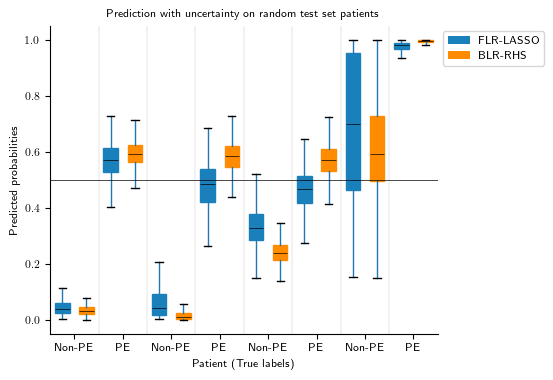

In [36]:
# List of row IDs
row_ids = BLR_RHS.index

# List of colors for BLR-RHS and FLR-ESNET
colors = ['#1a80bb', '#FF8C00']

# Create a figure and axes
fig, ax = plt.subplots(figsize=(5, 4))

# For each row ID
for i, row_id in enumerate(row_ids):
    # Create a new DataFrame with data for this row ID from the original DataFrames
    data = pd.DataFrame({
        'FLR_LASSO': FLR_LASSO.loc[row_id],
        'BLR_RHS': BLR_RHS.loc[row_id]
    })
    # Create a box plot for this data without displaying outliers
    bp = data.boxplot(ax=ax, positions=[i*2, i*2+1], widths=0.6, 
                      showfliers=False, patch_artist=True, return_type='dict')
    # Change the color of the boxes, whiskers, caps, and fliers
    for box, color in zip(bp['boxes'], colors):
        box.set_facecolor(color)
        box.set_edgecolor(color)
    for median in bp['medians']:
        median.set_color('black')
        median.set_linewidth(0.5)

# Add grid lines
for i in range(len(row_ids) - 1):
    ax.axvline(x=(i + 1) * 2 - 0.5, color='gray', linestyle='-', alpha=0.1)

# Update legend labels and patches for BLR-RHS and FLR-ESNET
legend_labels = ["FLR-LASSO", "BLR-RHS"]
legend_patches = [plt.Rectangle((0, 0), 1, 1, fc=color, edgecolor='none') for color in colors]
ax.legend(legend_patches, legend_labels, bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)

# Set the x-tick labels
ax.axhline(y = 0.5, lw = 0.5, color = "black")
ax.set_xticks([i*2+0.5 for i in range(len(row_ids))])
#ax.set_xticklabels([f"{'PE' if i % 2 else 'Non-PE'}" for i in range(len(row_ids))])
ax.set_xticklabels([f"{'PE' if i == 1 else 'Non-PE'}" for i in np.array(y_test)[indices]])
ax.grid(False)
plt.xlabel("Patient (True labels)", fontdict={'fontsize':8})
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.ylabel("Predicted probabilities", fontdict={'fontsize':8})
plt.title("Prediction with uncertainty on random test set patients", fontsize = 8)
#plt.savefig("plots/random_predictions.pdf", dpi=2000, bbox_inches="tight")
# Display the plot
plt.show()